In [14]:
import matplotlib.pyplot as plt
import gensim
import string
import pandas as pd
import numpy as np
from dsutils import make_semantic_model
from stimulus_utils import load_grids_for_stories, load_generic_trfiles
from dsutils import make_word_ds
from pydub import AudioSegment
import nibabel as nib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/anya/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def process_word(word):
    umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss', 
                       u':': u'', u',':'', u'.':'', u'\'': '', u')':'', u'(':'', '?':'', '"':'',
                        u'[':'', u']':'', '!':'', u'…': ''}
    word = word.decode('utf-8')

    for item, val in umlautDictionary.iteritems():
        word = word.replace(item, val)
    
    return word

In [33]:
model = gensim.models.Word2Vec.load_word2vec_format("/home/anya/Semantic-Atlas/models/german.model", binary=True)

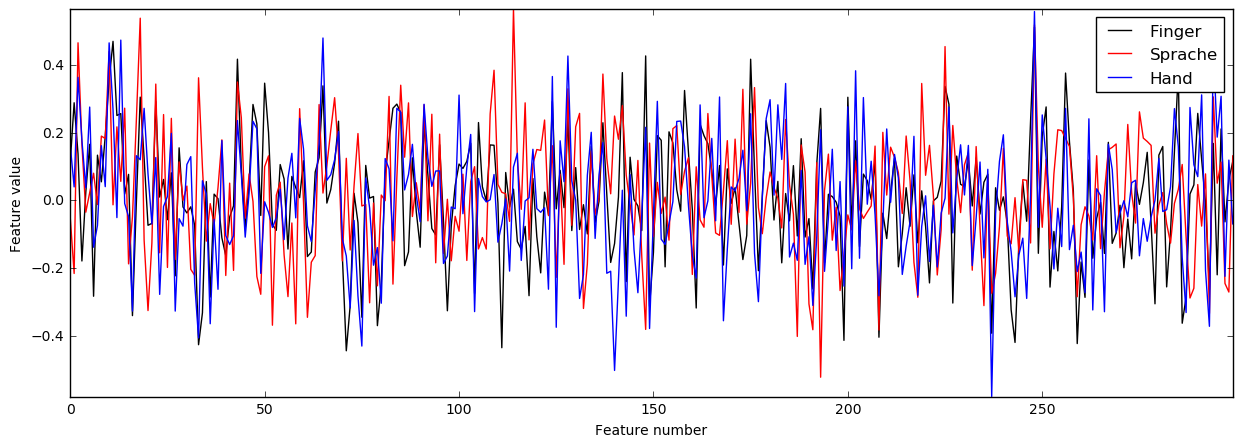

In [12]:
plot_words = ["Finger", "Sprache", "Hand"]
colors = ["k", "r", "b"]

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
wordlines = []

for word, color in zip(plot_words, colors):
    wordlines.append(ax.plot(model[word], color)[0])

ax.axis("tight")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")
ax.legend(wordlines, plot_words)

In [4]:
allsegments = ['0', '1']
grids = load_grids_for_stories(allsegments, grid_dir='/home/anya/Semantic-Atlas/data/aligned_segments/all_segments/')

In [18]:
audio = AudioSegment.from_file('/home/anya/Semantic-Atlas/audio/forrest_segments/fg_ad_seg0.mkv')
mri = nib.load('/home/anya/Semantic-Atlas/data/forrest_mri/segment0/bold.nii.gz').get_data()

In [36]:
def get_vector(word, model=model):
    try:
        return  model[word]
    except Exception as e:
        try:
            return model[word.title()]
        except Exception as e:
            print word
            return np.zeros(300)

In [46]:
def get_stimulus_matrix(segment_id, gr=False):
    folder_path_read = "/home/anya/Semantic-Atlas/data/aligned_segments/segment{}/".format(segment_id)
    
    if gr:
        file_in = folder_path_read + "/segment{}_words.txt".format(segment_id)
    else:
        file_in = folder_path_read + "/segment{}_words_srt.txt".format(segment_id)
        
    words_times = list()
    words_vectors = list()
    words = list()
    
    with open(file_in) as f_in:
        for line in f_in.readlines():
            start, end, word = line.rstrip().split('\t')
            words_times.append((float(start) + float(end)) / 2.)
            words_vectors.append(get_vector(word))
            words.append(word)
            
    return words, np.array(words_times), np.array(words_vectors)

In [51]:
words, wtimes, wvectors = get_stimulus_matrix(0)

bewoelktem
robertzemeckisfilm
sinise
mykelti
missis
zemeckis
hoerfilmfassung
–
hoerfilm
hochgewirbelt
wartebank
nikelaufschuhe
ausrasiert
kofferdeckel
curious
schwesterntracht
pfundweise
gewesen
peoplemagazine
zauberschuhe
kukluxklan
leintuecher
leintuecher
gullygitter
greenbow
greenbow
greenbowcountycentralschule
iq
curious
hutschachteln
missis
steigst
wartebank


In [53]:
wv.shape, wtimes

((1963, 300),
 array([   1.24,    2.3 ,    3.22, ...,  902.02,  902.02,  902.26]))

In [56]:
def lanczosfun(cutoff, t, window=3):
    """Compute the lanczos function with some cutoff frequency [B] at some time [t].
    [t] can be a scalar or any shaped numpy array.
    If given a [window], only the lowest-order [window] lobes of the sinc function
    will be non-zero.
    """
    t = t * cutoff
    val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)
    val[t==0] = 1.0
    val[np.abs(t)>window] = 0.0
    return val# / (val.sum() + 1e-10)

In [57]:
def lanczosinterp2D(data, oldtime, newtime, window=3, cutoff_mult=1.0, rectify=False):
    """Interpolates the columns of [data], assuming that the i'th row of data corresponds to
    oldtime(i). A new matrix with the same number of columns and a number of rows given
    by the length of [newtime] is returned.
    
    The time points in [newtime] are assumed to be evenly spaced, and their frequency will
    be used to calculate the low-pass cutoff of the interpolation filter.
    
    [window] lobes of the sinc function will be used. [window] should be an integer.
    """
    ## Find the cutoff frequency ##
    cutoff = 1/np.mean(np.diff(newtime)) * cutoff_mult
    print "Doing lanczos interpolation with cutoff=%0.3f and %d lobes." % (cutoff, window)
    
    ## Build up sinc matrix ##
    sincmat = np.zeros((len(newtime), len(oldtime)))
    for ndi in range(len(newtime)):
        sincmat[ndi,:] = lanczosfun(cutoff, newtime[ndi]-oldtime, window)
    
    if rectify:
        newdata = np.hstack([np.dot(sincmat, np.clip(data, -np.inf, 0)), 
                            np.dot(sincmat, np.clip(data, 0, np.inf))])
    else:
        ## Construct new signal by multiplying the sinc matrix by the data ##
        newdata = np.dot(sincmat, data)

    return newdata

In [82]:
new_times = map(lambda x: int(x + 1) if int(x + 1) % 2 == 0 else int(x + 2), wtimes)

In [83]:
newdata = lanczosinterp2D(wvectors, wtimes, new_times)

Doing lanczos interpolation with cutoff=2.175 and 3 lobes.


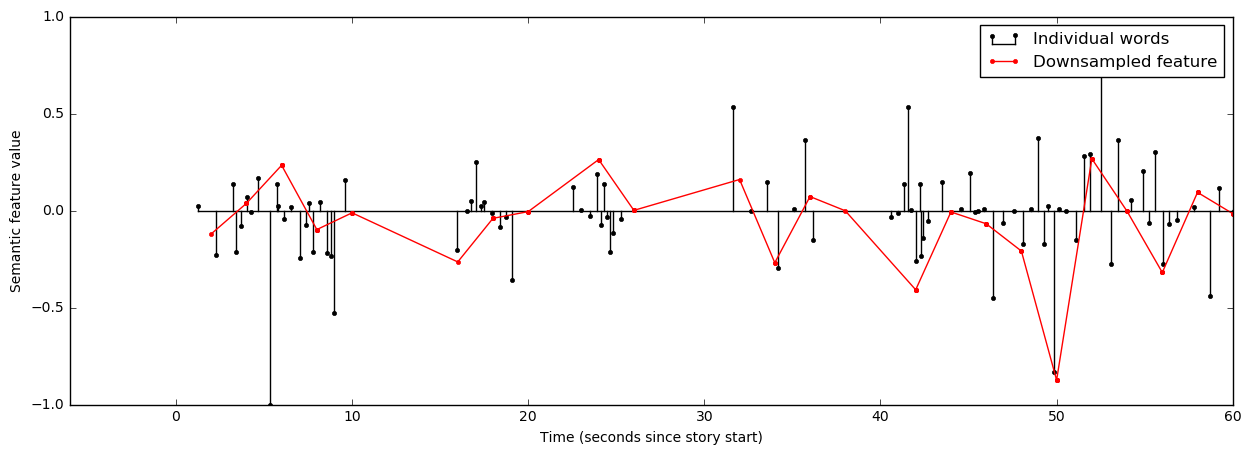

In [84]:
f = figure(figsize=(15,5))
f.clf()
schan = 150
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(wtimes, 
                    wvectors[:,schan] / np.abs(wvectors[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(new_times, 
                  newdata[:,schan] / np.abs(newdata[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

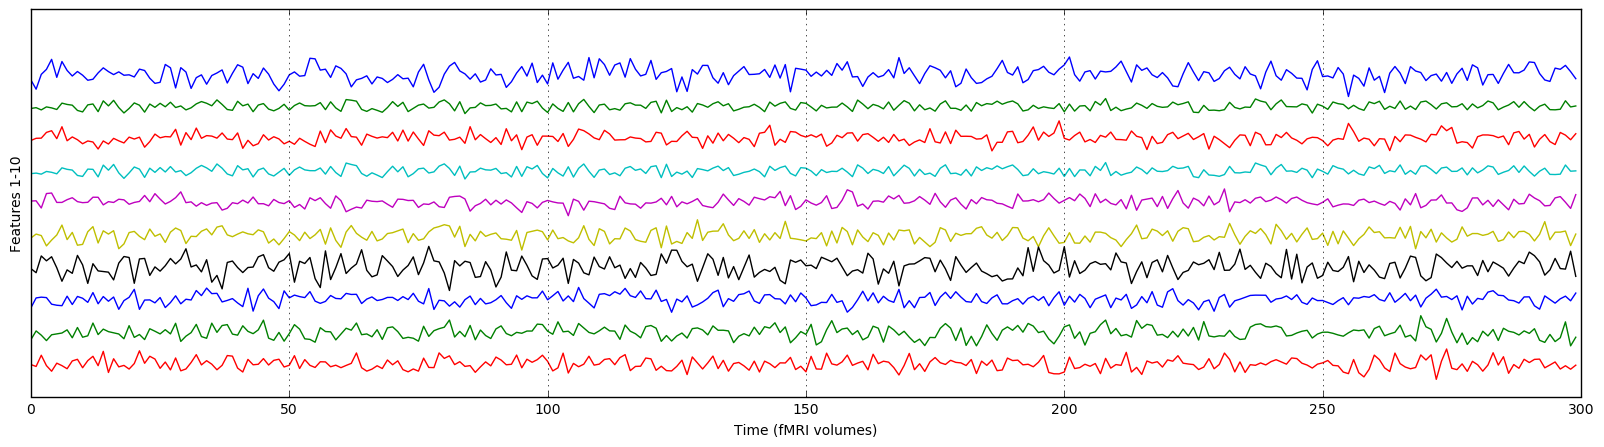

In [89]:
# Plot some of the combined stimuli
from random import choice
from npp import zscore

newdata_scored = zscore(newdata)      
ind_range = range(300)

f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(1, 300, 30):
    ax.plot(newdata_scored[ii] - ii/6)

#ax.set_xlim(0, 952)
ax.set_yticks([])
#ax.set_xticks(range(0, 952, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

In [91]:
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

delayed_wvectors = make_delayed(newdata_scored, delays)

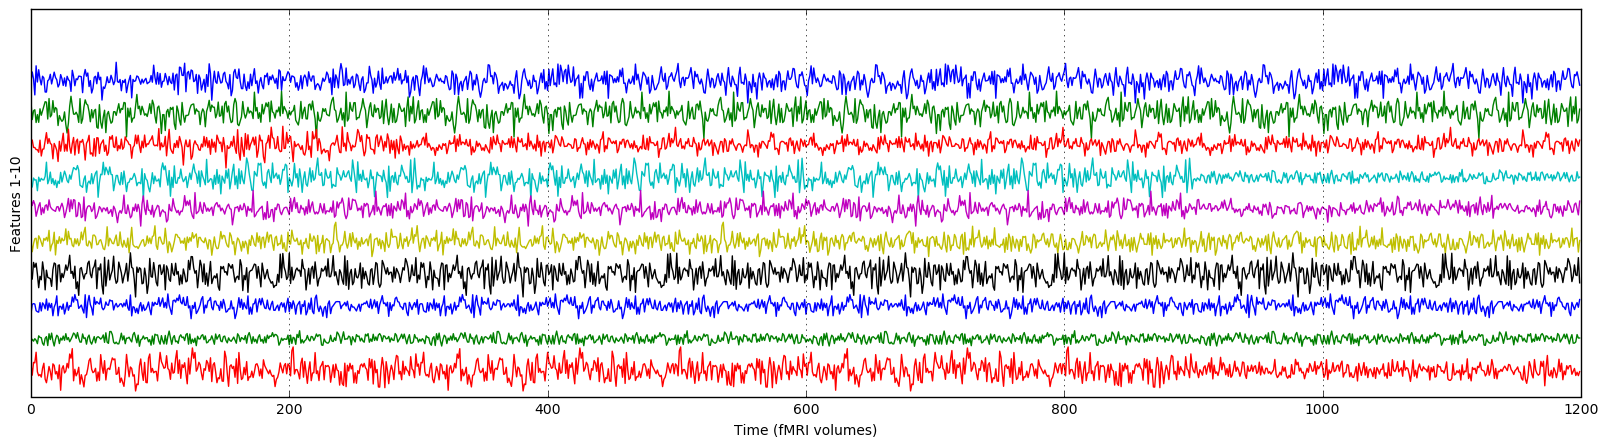

In [96]:
newdata_scored = zscore(newdata)      
ind_range = range(300)

f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(6, 300, 30):
    ax.plot(delayed_wvectors[ii] - ii/6)

#ax.set_xlim(0, 952)
ax.set_yticks([])
#ax.set_xticks(range(0, 952, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

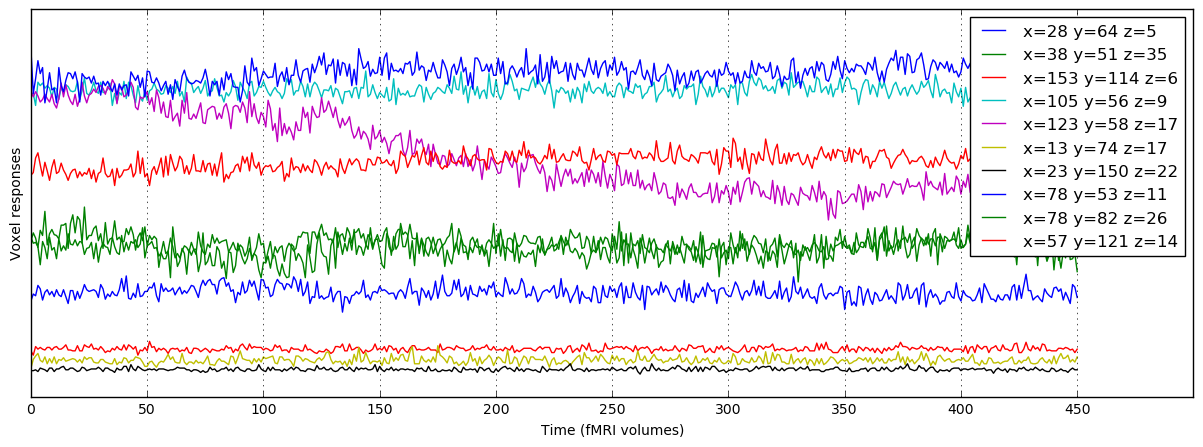

In [109]:
selvoxels = [[choice(range(160)), choice(range(160)), choice(range(36))] for _ in range(10)]

f = figure(figsize=(15, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selvoxels):
    ax.plot(mri[vi[0], vi[1], vi[2]] - 5 * ii, label="x={} y={} z={}".format(vi[0], vi[1], vi[2]))
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Voxel responses")
ax.legend()
ax.grid()

In [113]:
mri.shape

(160, 160, 36, 451)

In [120]:
mri_raveled = np.zeros((160 * 160 * 36, mri.shape[-1]))
i = 0
for x in range(160):
    for y in range(160):
        for z in range(36):
            mri_raveled[i] = mri[x,y,z]
            i += 1

In [123]:
mri_raveled = np.transpose(mri_raveled)

In [124]:
mri_raveled.shape

(451, 921600)

In [ ]:
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 5 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delayed_wvectors, mri_raveled, delayed_wvectors, mri_raveled,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

In [118]:
delayed_wvectors.shape

(1963, 1200)